In [1]:
# Muhammad Arslan Zafar 218203179
# Muhammad Ahmed Shehzad 218203458
# Muhammad Naeem 218100998
# Sevinj Guluzade 219100888
# Davud Ismayilov 219203057

In [2]:
from pyspark.sql import SparkSession

# visual libraries
from matplotlib import pyplot as plt
import geopandas
import geoplot
from pyproj import CRS

import pandas_bokeh
pandas_bokeh.output_notebook()

import seaborn as sns
sns.set()

import pandas as pd
import numpy as np

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

Loading BokehJS ...

In [3]:
# create sparksession
spark = SparkSession.builder.appName("COVID").config("spark.some.config.option", "some-value").getOrCreate()
confirmed = spark.read.csv('time_series_19-covid-Confirmed_archived_0325.csv', header=True, inferSchema = True)

In [4]:
# I will start by creating temporary tables querying with SQL
confirmed.createOrReplaceTempView('COVID_Confirmed')
spark.sql('''SELECT * FROM COVID_Confirmed''').show()

+----------------+--------------------+--------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|  Province/State|      Country/Region|     Lat|     Long|1/22/20|1/23/20|1/24/20|1/25/20|1/26/20|1/27/20|1/28/20|1/29/20|1/30/20|1/31/20|2/1/20|2/2/20|2/3/20|2/4/20|2/5/20|2/6/20|2/7/20|2/8/20|2/9/20|2/10/20|2/11/20|2/12/20|2/13/20|2/14/20|2/15/20|2/16/20|2/17/20|2/18/20|2/19/20|2/20/20|2/21/20|2/22/20|2/23/20|2/24/20|2/25/20|2/26/20|2/27/20|2/28/20|2/29/20|3/1/20|3/2/20|3/3/20|3/4/20|3/5/20|3/6/20|3/7/20|3/8/20|3/9/20|3/10/20|3/11/20|3/12/20|3/13/20|3/14/20

In [5]:
confirmed = spark.sql(
'''
SELECT * FROM COVID_Confirmed 
WHERE `Country/Region` = 'Australia'
'''
).toPandas()

In [6]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,112,134,171,210,267,307,353,436,533,533
1,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,49,57,71,94,121,121,121,229,296,296
2,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,46,61,68,78,94,144,184,221,221,221
3,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,19,20,29,29,37,42,50,67,100,100
4,From Diamond Princess,Australia,35.4437,139.6380,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# extract data of last 2 days
column_values = confirmed
confirmed_cases_to_predict = confirmed.iloc[:, -2:]
confirmed_cases_to_predict

,3/22/20,3/23/20
0,533,533
1,296,296
2,221,221
3,100,100
4,0,0
5,120,120
6,22,22
7,3,3
8,19,19


In [8]:
del confirmed['3/22/20']
del confirmed['3/23/20']

In [9]:
# merge data for last 2 days
before_prediction = confirmed_cases_to_predict.sum(axis = 0, skipna = True).tolist()
before_prediction

[1314, 1314]

In [10]:
# take confirmed cases data from 2/1/20 till 3/21/20 and merge it
cofirmed_cases_dates = confirmed.iloc[:, 14:]
confirmed_cases_sum_of_each_date = cofirmed_cases_dates.sum(axis = 0, skipna = True).tolist()
confirmed_cases_sum_of_each_date

[12,
 12,
 12,
 13,
 13,
 14,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 19,
 22,
 22,
 22,
 22,
 22,
 23,
 23,
 25,
 27,
 30,
 39,
 52,
 55,
 60,
 63,
 76,
 91,
 107,
 128,
 128,
 200,
 250,
 297,
 377,
 452,
 568,
 681,
 791,
 1071]

In [11]:
# show data in visualisation
confirmed.plot_bokeh(kind='bar', x='Province/State', y = list(confirmed.columns.values),
              xlabel='Provinces / States', ylabel='Frequency', 
              legend=False, title='Frequency by Days', figsize=(1000, 500))

Figure(id='1038', ...)

In [12]:
gpdf = geopandas.GeoDataFrame(confirmed, geometry=geopandas.points_from_xy(confirmed.Long, confirmed.Lat))
gpdf.crs = CRS.from_string("epsg:4326")
gpdf.plot_bokeh(legend=False)

Figure(id='2111', ...)

In [13]:
# create merged dataframe of confirmed cases from 2/1/20 till 3/20/20
audf = pd.DataFrame({'Dates':list(cofirmed_cases_dates.columns.values), 'Cases':confirmed_cases_sum_of_each_date})
audf

,Dates,Cases
0,2/1/20,12
1,2/2/20,12
2,2/3/20,12
3,2/4/20,13
4,2/5/20,13
5,2/6/20,14
6,2/7/20,15
7,2/8/20,15
8,2/9/20,15
9,2/10/20,15


In [14]:
audf.plot_bokeh(kind='line', legend=False, figsize=(1000, 500))

Figure(id='2236', ...)

In [15]:
# apply linear regression
confirmed_cases_reshape = np.arange(len(cofirmed_cases_dates.columns.values)).reshape(-1, 1)
regressor = LinearRegression().fit(confirmed_cases_reshape, confirmed_cases_sum_of_each_date)
regressor

LinearRegression()

In [16]:
# linear regression 
regressor.coef_,regressor.intercept_

(array([10.35471789]), -133.11058823529413)

In [17]:
# get predictions for 3/22/20 and 3/23/20
predictions = []
for prediction in range(0, 2):
    predictions.append(regressor.predict(np.array([[confirmed_cases_reshape[-1][0] + prediction]])).astype(int))

predictions = np.asarray(predictions).reshape(2)
predictions

array([374, 384])

In [18]:
# find the difference between actual and predicted value 
difference = before_prediction - predictions
difference

array([940, 930])

In [19]:
# created predicted dataframe with predicted values for  3/22/20 and 3/23/20
confirmed_cases_sum_of_each_date.append(predictions[0])
confirmed_cases_sum_of_each_date.append(predictions[1])

predicted_dataframe = {}
dates = column_values.iloc[:, 14: -1].columns.values.tolist()
dates.append("3/22/20")
dates.append("3/23/20")
dates

['2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20']

In [20]:
confirmed_cases_sum_of_each_date

for key in dates: 
    for value in confirmed_cases_sum_of_each_date: 
        predicted_dataframe[key] = value 
        confirmed_cases_sum_of_each_date.remove(value) 
        break 
predicted_dataframe

{'2/1/20': 12,
 '2/2/20': 12,
 '2/3/20': 12,
 '2/4/20': 13,
 '2/5/20': 13,
 '2/6/20': 14,
 '2/7/20': 15,
 '2/8/20': 15,
 '2/9/20': 15,
 '2/10/20': 15,
 '2/11/20': 15,
 '2/12/20': 15,
 '2/13/20': 15,
 '2/14/20': 15,
 '2/15/20': 15,
 '2/16/20': 15,
 '2/17/20': 15,
 '2/18/20': 15,
 '2/19/20': 15,
 '2/20/20': 15,
 '2/21/20': 19,
 '2/22/20': 22,
 '2/23/20': 22,
 '2/24/20': 22,
 '2/25/20': 22,
 '2/26/20': 22,
 '2/27/20': 23,
 '2/28/20': 23,
 '2/29/20': 25,
 '3/1/20': 27,
 '3/2/20': 30,
 '3/3/20': 39,
 '3/4/20': 52,
 '3/5/20': 55,
 '3/6/20': 60,
 '3/7/20': 63,
 '3/8/20': 76,
 '3/9/20': 91,
 '3/10/20': 107,
 '3/11/20': 128,
 '3/12/20': 128,
 '3/13/20': 200,
 '3/14/20': 250,
 '3/15/20': 297,
 '3/16/20': 377,
 '3/17/20': 452,
 '3/18/20': 568,
 '3/19/20': 681,
 '3/20/20': 791,
 '3/21/20': 1071,
 '3/22/20': 374,
 '3/23/20': 384}

In [21]:
predicted_result = pd.DataFrame(predicted_dataframe.items(), columns=['Date', 'Cases'])
predicted_result.plot_bokeh(kind='line', legend=False, figsize=(1000, 500))

Figure(id='2353', ...)

In [22]:
# create dataframe with actual values for  3/22/20 and 3/23/20
predicted_result['Date']=predicted_result.index
actual_values=predicted_result.set_index('Date')
actual_values.iloc[50,0]=1314
actual_values.iloc[51,0]=1314
actual_values=actual_values.reset_index()
actual_values

,Date,Cases
0,0,12
1,1,12
2,2,12
3,3,13
4,4,13
5,5,14
6,6,15
7,7,15
8,8,15
9,9,15


In [23]:
# create dataframe with difference between actual and predicted values for 3/22/20 and 3/23/20.
data=[[50,940],[51,930]]
df=pd.DataFrame(data, columns=['Date', 'difference'])
df

,Date,difference
0,50,940
1,51,930


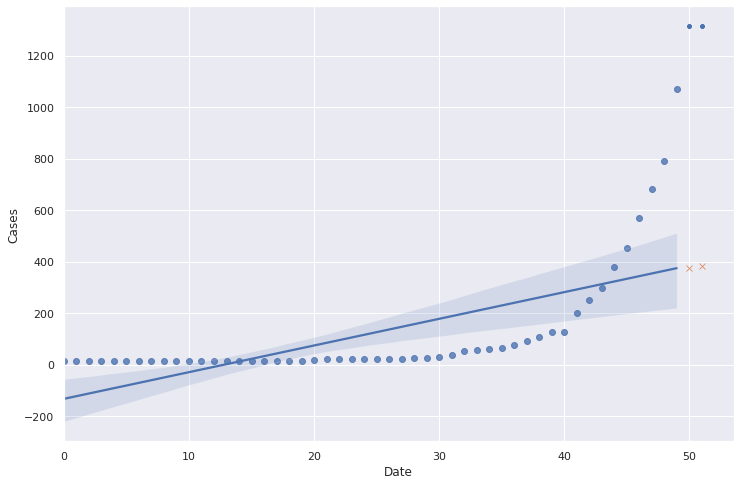

In [24]:
# create regression plot
f, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='Date',y='Cases',data=predicted_result.iloc[:-2,:])
sns.scatterplot(x='Date',y='Cases',data=actual_values.iloc[-2:,:])
sns.scatterplot(x='Date',y='Cases',data=predicted_result.iloc[-2:,:],marker='x')

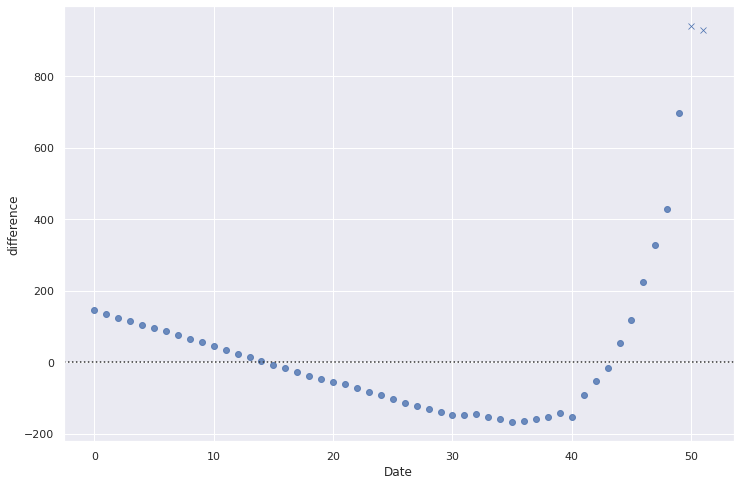

In [25]:
# create residual plot
f, ax = plt.subplots(figsize=(12, 8))
sns.residplot(x='Date',y='Cases',data=predicted_result.iloc[:-2,:])
sns.scatterplot(x='Date',y='difference',data=df,marker='x')